# Baseline FMDT one sample at a time


In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH
from graphviz import Digraph
from collections import OrderedDict


%matplotlib inline

In [2]:
fc = 1.12 # center frequency GHz
bw = 0.288 # bandwidth GHz
Nd = 512 # number of DM trials
Nchan= 256
Nt = 256 # time block size
Tint = 0.864e-3 # integration time - seconds
Npol = 2 # input number of polarisations
Npix = 256
ignore_ant = ['ak31','ak32','ak33','ak34','ak35','ak36']
f1 = fc - bw/2.
f2 = fc + bw/2.
chanbw = 1e-3
lam1 = constants.c/f1/1e9
lam2 = constants.c/f2/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2


print lam1, lam2, lambdas.min(), lambdas.max(), freqs.min(), freqs.max()
configs = ((2,2), (4, 4), (8,8), (16,16), (32,32), (64,64),(128,128),(256,256),(1024,256),(1024,288),(256,288),(32,288))


0.307164403689 0.237177577532 0.24353570917952883 0.30716440368852455 0.9760000000000001 1.231


In [3]:
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)
print(dir(thefdmt))


['__call__', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calc_delta_t', '_df_bot', '_df_top', '_execute_iteration', '_ndt_top', '_save_iteration', '_state_shape', 'add_frb_track', 'bw', 'd_f', 'execute', 'f_max', 'f_min', 'get_eff_sigma', 'get_eff_var_recursive', 'hist_delta_t', 'hist_nf_data', 'hist_state_shape', 'init_delta_t', 'init_history', 'initialise', 'max_dt', 'max_state_size', 'n_f', 'n_t', 'niter', 'trace_dm']


In [4]:
def fmt(i,c,d):
    return 'I{}D{}C{}'.format(i,d,c)

maindot = Digraph(comment='FDMT', format='png')
all_offsets = []
nnodes = 0
nplotnodes = 0
output_fifo_sizes = {}

# make initial nodes
ishape = thefdmt.hist_state_shape[0]
dot = Digraph(name='cluster_iter0')
dot.attr(label='Iteration 0')
maindot.subgraph(dot)
for c in xrange(ishape[0]):
    for d in xrange(ishape[1]):
        maindot.node(fmt(0, c, d))
        nnodes += 1
        nplotnodes += 1

        
for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    out_shape = thefdmt.hist_state_shape[iterno+1]
    in_shape = thefdmt.hist_state_shape[iterno]
    nchan, ndt, nt_out = out_shape
    print 'Iteration {} in={}={} out={}={}'.format(iterno, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
    dot = Digraph(name='cluster_iter{}'.format(iterno+1))
    dot.attr(label='Iteration {}'.format(iterno+1))
    maindot.subgraph(dot)

    for ochan in xrange(nchan):
        chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
        #print '\tOut channel {}'.format(ochan)
        last_id1 = -1
        last_id2 = -1
        for idt, config in enumerate(chanconfig):
            _, id1, offset, id2, _, _, _ = config
            do_copy = id2 == -1
            inchan1 = 2*ochan
            inchan2 = inchan1+1
            id1_hit = ''
            id2_hit = ''
            if last_id1 == id1:
                id1_hit = '*'
            if last_id2 == id2:
                id2_hist = '*'
            
            #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
            #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)
            
            all_offsets.append(offset)
            style = 'dashed' if do_copy else 'solid'
            nnodes += 1
            label = None if offset == 0 else 'd={}'.format(offset)
            n1 = fmt(iterno, inchan1, id1)
            n2 = fmt(iterno, inchan2, id2)
            nout = fmt(iterno+1,ochan, idt)
            
            # For a given sum - only maintain 1 fifo of the given max length
            ff = output_fifo_sizes.get(n2, [])
            ff.append(offset)
            output_fifo_sizes[n2] = ff
            
            #addnode = iterno >= 6 and idt > thefdmt.hist_state_shape[iterno+1][1]*0.9
            addnode = True
            if addnode:
                maindot.node(fmt(iterno+1,ochan, idt), style=style)
                nplotnodes += 1
                maindot.edge(n1, nout)
                if not do_copy:
                    color = 'black' if offset == 0 else 'red'
                    maindot.edge(n2, nout,label=label, color=color)
    
            last_id1 = id1
            last_id2 = id2

    
nfifo_outputs = {k:max(ff) for k, ff in output_fifo_sizes.iteritems()}
bulk_fifo_sizes = {k:min(ff) for k, ff in output_fifo_sizes.iteritems()}
fanout_fifo_sizes = {k:max(ff) - min(ff) for k, ff in output_fifo_sizes.iteritems()}

print 'Total offsets', sum(all_offsets), 'nfifo outputs', sum(nfifo_outputs.values()), 'largest fifo', max(nfifo_outputs.values()), 'total nodes', nnodes

Iteration 0 in=[256   4 256]=1024 out=[128   7 263]=896
Iteration 1 in=[128   7 263]=896 out=[ 64  13 269]=832
Iteration 2 in=[ 64  13 269]=832 out=[ 32  24 280]=768
Iteration 3 in=[ 32  24 280]=768 out=[ 16  45 301]=720
Iteration 4 in=[ 16  45 301]=720 out=[  8  87 343]=696
Iteration 5 in=[  8  87 343]=696 out=[  4 165 421]=660
Iteration 6 in=[  4 165 421]=660 out=[  2 301 557]=602
Iteration 7 in=[  2 301 557]=602 out=[  1 512 768]=512
Total offsets 152088 nfifo outputs 67617 largest fifo 301 total nodes 5492


In [5]:
print 'nplotnodes', nplotnodes
if nplotnodes < 1200:
    maindot.view()
    
print all_offsets

nplotnodes 5492
[0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2, 2, 3, 4, 0, 1, 2,

******** total
num FIFOs 1983
Total SR entries 67617
Number of SR length ==0 0
Number of SR length ==1 127
Number of SR length ==2 205
Number of SR length >=1 1983
Number of SR length <=16 1226
Number of SR length <=32 1456
Number of SR length <=64 1662
Number of SR length >64 321
Number of SR length >128 152
Number of SR length >256 32
Number of SR length >512 0
Max SR length 301
******** bulk
num FIFOs 1983
Total SR entries 65132
Number of SR length ==0 255
Number of SR length ==1 127
Number of SR length ==2 191
Number of SR length >=1 1728
Number of SR length <=16 1250
Number of SR length <=32 1467
Number of SR length <=64 1667
Number of SR length >64 316
Number of SR length >128 150
Number of SR length >256 31
Number of SR length >512 0
Max SR length 300
******** fanout
num FIFOs 1983
Total SR entries 2485
Number of SR length ==0 64
Number of SR length ==1 1372
Number of SR length ==2 528
Number of SR length >=1 1919
Number of SR length <=16 1983
Number of SR length <=32 1983
Numbe

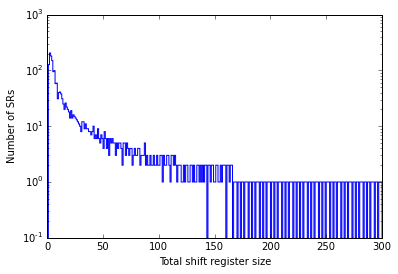

In [6]:

total_offsets = np.array(nfifo_outputs.values())
bulk_sizes = np.array(bulk_fifo_sizes.values())
fanout_sizes = np.array(fanout_fifo_sizes.values())

def print_sr_stats(all_offsets):
    print "num FIFOs", len(all_offsets)
    print 'Total SR entries', sum(all_offsets)
    print 'Number of SR length ==0', sum(all_offsets == 0)
    print 'Number of SR length ==1', sum(all_offsets == 1)
    print 'Number of SR length ==2', sum(all_offsets == 2)
    print 'Number of SR length >=1', sum(all_offsets >= 1)
    print 'Number of SR length <=16', sum(all_offsets <= 16)
    print 'Number of SR length <=32', sum(all_offsets <= 32)
    print 'Number of SR length <=64', sum(all_offsets <= 64)
    print 'Number of SR length >64', sum(all_offsets >64)
    print 'Number of SR length >128', sum(all_offsets >128)
    print 'Number of SR length >256', sum(all_offsets >256)
    print 'Number of SR length >512', sum(all_offsets >512)

    print 'Max SR length', max(all_offsets)

print '*'*8, 'total'
print_sr_stats(total_offsets)

print '*'*8, 'bulk'
print_sr_stats(bulk_sizes)

print '*'*8, 'fanout'
print_sr_stats(fanout_sizes)

x = hist(total_offsets, np.arange(0, max(total_offsets), 1), log=True, histtype='step')
xlabel('Total shift register size')
ylabel('Number of SRs')

Total offsets 67617  total sum operations 4468


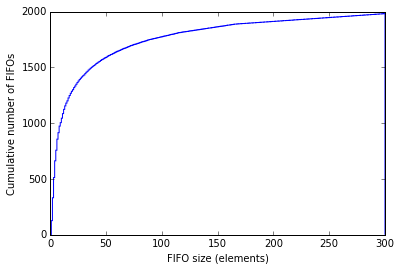

In [7]:
print 'Total offsets', sum(total_offsets), ' total sum operations', len(all_offsets)
hist(total_offsets, np.arange(0, max(total_offsets), 1), log=False, cumulative=True, histtype='step')
xlabel('FIFO size (elements)')
ylabel('Cumulative number of FIFOs')


#xlim(0, 50)

Total offsets 67617  total sum operations 4468


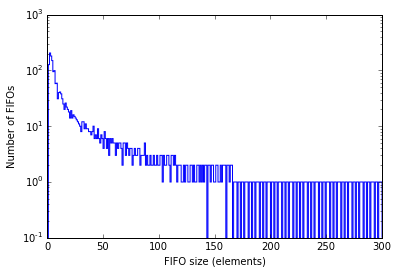

In [8]:
print 'Total offsets', sum(total_offsets), ' total sum operations', len(all_offsets)
hist(total_offsets, np.arange(0, max(total_offsets), 1), log=True, cumulative=False, histtype='step')
xlabel('FIFO size (elements)')
ylabel('Number of FIFOs')



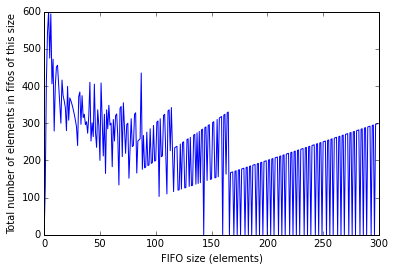

In [9]:
plot(x[1][0:-1], x[0]*(x[1][0:-1]))
xlabel('FIFO size (elements)')
ylabel('Total number of elements in fifos of this size')

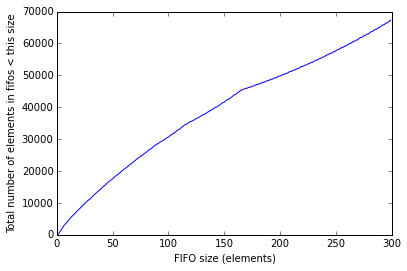

In [10]:
plot(x[1][0:-1], np.cumsum(x[0]*(x[1][0:-1])))
xlabel('FIFO size (elements)')
ylabel('Total number of elements in fifos < this size')

In [11]:
num_outputs = [len(ff) for ff in output_fifo_sizes.values()]
max_ff_length = [max(ff) for ff in output_fifo_sizes.values()]
ff_length_range = [max(ff) - min(ff) for ff in output_fifo_sizes.values()]

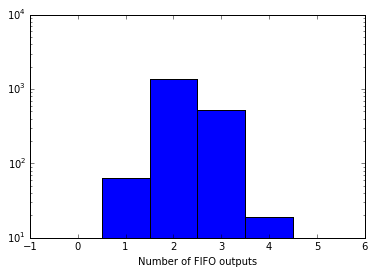

In [12]:
hist(num_outputs, np.arange(0, max(num_outputs)+3) - 0.5, log=True)
xlabel('Number of FIFO outputs')

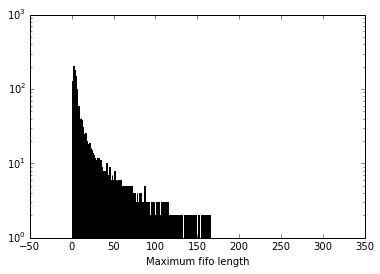

In [13]:
hist(max_ff_length, np.arange(0, max(max_ff_length)+3) - 0.5, log=True)
xlabel('Maximum fifo length')

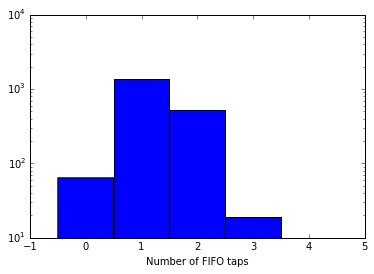

In [14]:
hist(ff_length_range, np.arange(0, max(ff_length_range)+3) - 0.5, log=True)
xlabel('Number of FIFO taps')

In [15]:
def make_c_file(thefdmt):
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''
#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//

const int NC={f.n_f}; // Number of channels
const float FMIN = {f.f_min}; // Frequency of bottom channel (GHz)
const float FMAX = {f.f_max}; // Frequency of bottom channel (GHz)
const int ND = {f.max_dt}; // Number of output DM trials
const int ND_IN = {f.hist_state_shape[0][1]}; // number of input dm trials
const float DF = {f.d_f}; // channel interval (GHz)
const float BW = {f.bw}; // Total bandwidth (GHz)

'''.format(f=thefdmt)
    ishape = thefdmt.hist_state_shape[0]
    read = '// Read inputs\n'
    for c in xrange(ishape[0]):
        for d in xrange(ishape[1]):
            read += 'fdmt_t {} = in[{}][{}];\n'.format(fmt(0, c, d), d,c)


    queuedecl = '// FIFO declarations\n\n'
    queuepush = '// FIFO push statements\n\n'
    do_sums = ''
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape
        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        
        do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        
        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff
                
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += 'fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += 'fdmt_t {} = {} + {}_fifo.read({});\n'.format(nout, n1, n2, offset)
                        

    for infmt, ff_sizes in output_fifo_sizes.iteritems():
        #queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
        #queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)
        # add 1 because of how lengths are defined. Ap_shift_reg wants size, fdmt_fifo wanted max_read_value
        queuedecl += 'static ap_shift_reg<fdmt_t, {}> {}_fifo;\n'.format(max(ff_sizes)+1, infmt);
        queuepush += '{}_fifo.shift({});\n'.format(infmt, infmt)
    
    # write outputs
    oshape = thefdmt.hist_state_shape[iterno+1]

    write = '\n\n// Write outputs\n\n'
    for c in xrange(oshape[0]):
        for d in xrange(oshape[1]):
            write += 'out[{}] = {};\n'.format(d, fmt(iterno+1, c, d))

                
    funcstart = '''
    void fdmt_process(fdmt_t in[ND_IN][NCHAN], fdmt_t out[ND]) {
    
    #pragma HLS PIPELINE II=16
    '''
    funcend = '''
    }
    
#
    '''
    
    fileend = "#endif"
    cfile = preamble  + queuedecl + read + do_sums + queuepush + write + fileend
    
    return cfile


s = make_c_file(thefdmt)
fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}.h'.format(f=thefdmt)
print('Writing to ', fout)
#print(s)
with open(fout, 'w') as fout:
    fout.write(s)
    
    

Iteration 1 in=[256   4] size=1024 out=[128   7] size=896
Iteration 2 in=[128   7] size=896 out=[64 13] size=832
Iteration 3 in=[64 13] size=832 out=[32 24] size=768
Iteration 4 in=[32 24] size=768 out=[16 45] size=720
Iteration 5 in=[16 45] size=720 out=[ 8 87] size=696
Iteration 6 in=[ 8 87] size=696 out=[  4 165] size=660
Iteration 7 in=[  4 165] size=660 out=[  2 301] size=602
Iteration 8 in=[  2 301] size=602 out=[  1 512] size=512
('Writing to ', 'fdmt_d512_c256_f0.976.h')


In [16]:
for nd, nchan in configs:
    thefdmt = fdmt.Fdmt(f1, chanbw, nchan, nd, Nt)
    s = make_c_file(thefdmt)
    fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}.h'.format(f=thefdmt)
    print('Writing to ', fout)
    #print(s)
    with open(fout, 'w') as fout:
        fout.write(s)

Iteration 1 in=[2 2] size=4 out=[1 2] size=2
('Writing to ', 'fdmt_d2_c2_f0.976.h')
Iteration 1 in=[4 2] size=8 out=[2 3] size=6
Iteration 2 in=[2 3] size=6 out=[1 4] size=4
('Writing to ', 'fdmt_d4_c4_f0.976.h')
Iteration 1 in=[8 2] size=16 out=[4 3] size=12
Iteration 2 in=[4 3] size=12 out=[2 5] size=10
Iteration 3 in=[2 5] size=10 out=[1 8] size=8
('Writing to ', 'fdmt_d8_c8_f0.976.h')
Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976.h')
Iteration 1 in=[32  3] size=96 out=[16  4] size=64
Iteration 2 in=[16  4] size=64 out=[8 6] size=48
Iteration 3 in=[8 6] size=48 out=[ 4 10] size=40
Iteration 4 in=[ 4 10] size=40 out=[ 2 17] size=34
Iteration 5 in=[ 2 17] size=34 out=[ 1 32] size=32
('Writing to ', 'fdmt_d32_c32_f0.976.h')
Iteration 1 in=[64  3] size=192 out=[32  4] size=128
Iteration 2 in=[32  4] size=12

In [17]:
def make_c_file_iter(thefdmt):
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''
#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//

const int NC={f.n_f}; // Number of channels
const float FMIN = {f.f_min}; // Frequency of bottom channel (GHz)
const float FMAX = {f.f_max}; // Frequency of bottom channel (GHz)
const int ND = {f.max_dt}; // Number of output DM trials
const int ND_IN = {f.hist_state_shape[0][1]}; // number of input dm trials
const float DF = {f.d_f}; // channel interval (GHz)
const float BW = {f.bw}; // Total bandwidth (GHz)

'''.format(f=thefdmt)
    ishape = thefdmt.hist_state_shape[0]
    
    iters = ''
    

    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape

        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        ncout, ndout = out_shape[0:2]
        ncin, ndin = in_shape[0:2]
        sums_done = set()
        queuedecl = ''
        queuedecl += '//Iteration {iterno}\n'.format(**locals())
        if ncout == 1:
            queuedecl += 'void iteration{iterno}(const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}]) \n'.format(**locals())
        else:
            queuedecl += 'void iteration{iterno}(const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}][{ncout}]) \n'.format(**locals())

        queuedecl += '{\n'
        queuedecl += '// FIFO declarations\n\n'
        queuepush = '// FIFO push statements\n\n'
        do_sums = ''
        #do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        read = ' '*4 + '// Read inputs\n'
        for c in xrange(ncin):
            for d in xrange(ndin):
                read += '    fdmt_t {} = in[{}][{}];\n'.format(fmt(iterno, c, d), d,c)
                

        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff
                
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += '    fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += '    fdmt_t {} = {} + {}_fifo.read({});\n'.format(nout, n1, n2, offset)
                        
                sums_done.add((ochan, idt))
                        

        # Find FIFOS for this iteration
        myfifos = filter(lambda f: f.startswith('I{}'.format(iterno)), output_fifo_sizes)
        for infmt in myfifos:
            ff_sizes = output_fifo_sizes[infmt]
            #queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
            #queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)
            # add 1 because of how lengths are defined. Ap_shift_reg wants size, fdmt_fifo wanted max_read_value
            queuedecl += '    static ap_shift_reg<fdmt_t, {}> {}_fifo;\n'.format(max(ff_sizes)+1, infmt);
            queuepush += '    {}_fifo.shift({});\n'.format(infmt, infmt)

        # write outputs
        oshape = thefdmt.hist_state_shape[iterno+1]

        write = '\n\n// Write outputs\n\n'
        for c in xrange(ncout):
            for d in xrange(ndout):
                if (c, d) in sums_done: # if the sum was actually done - load it into the array
                    write += '    out[{}][{}] = {};\n'.format(d, c , fmt(iterno+1, c, d))
                else:
                    write += '    out[{}][{}] = {};\n'.format(d, c , 0) # set the few dangling outputs to zero
                
        
        iters += queuedecl + read  + do_sums + queuepush + write + '}\n\n'
                
    funcstart = '''void fdmt_process(fdmt_t in[ND_IN][NC], fdmt_t out[ND]) { 
    #pragma HLS PIPELINE II=16
'''
    funcdecl = ''
    funcrun = ''
    lastiter = len(thefdmt.hist_nf_data) -1
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        nextiter = iterno+1
        out_shape = thefdmt.hist_state_shape[nextiter]
        in_shape = thefdmt.hist_state_shape[iterno]
        if iterno != 0:
            funcdecl += '    fdmt_t d_iter{i}[{nd}][{nc}];\n'.format(i=iterno,nc=in_shape[0], nd=in_shape[1])
            
        if iterno == 0:
            funcrun += '    iteration{iterno}(in, d_iter{nextiter});\n'.format(**locals())
        elif iterno == lastiter:
            funcrun += '    iteration{iterno}(d_iter{iterno}, out);\n'.format(**locals())
        else:
            funcrun += '    iteration{iterno}(d_iter{iterno}, d_iter{nextiter});\n'.format(**locals())

    
    funcend = '''
}
'''
    
    fileend = "#endif"
    cfile = preamble  + iters + funcstart + funcdecl + funcrun + funcend + fileend
    
    return cfile


thefdmt = fdmt.Fdmt(f1, chanbw, 32, 32, Nt)

s = make_c_file_iter(thefdmt)
fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_iter.h'.format(f=thefdmt)
print('Writing to ', fout)
print(s)
with open(fout, 'w') as fout:
    fout.write(s)
    
    

Iteration 1 in=[32  3] size=96 out=[16  4] size=64
Iteration 2 in=[16  4] size=64 out=[8 6] size=48
Iteration 3 in=[8 6] size=48 out=[ 4 10] size=40
Iteration 4 in=[ 4 10] size=40 out=[ 2 17] size=34
Iteration 5 in=[ 2 17] size=34 out=[ 1 32] size=32
('Writing to ', 'fdmt_d32_c32_f0.976_iter.h')

#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd=32 nf=32 fmin=0.976 nchan=32 df=0.001 bw=0.032
//

const int NC=32; // Number of channels
const float FMIN = 0.976; // Frequency of bottom channel (GHz)
const float FMAX = 1.008; // Frequency of bottom channel (GHz)
const int ND = 32; // Number of output DM trials
const int ND_IN = 3; // number of input dm trials
const float DF = 0.001; // channel interval (GHz)
const float BW = 0.032; // Total bandwidth (GHz)

//Iteration 0
void iteration0(const fdmt_t in[3][32], fdmt_t out[4][16]) 
{
// FIFO declarations

    static ap_shift_reg<fdmt_t, 3> I0D0C1_fifo;
    static ap_shift_reg<fdm

In [18]:
for nd, nchan in configs:
    thefdmt = fdmt.Fdmt(f1, chanbw, nchan, nd, Nt)
    s = make_c_file_iter(thefdmt)
    fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_iter.h'.format(f=thefdmt)
    print('Writing to ', fout)
    #print(s)
    with open(fout, 'w') as fout:
        fout.write(s)

Iteration 1 in=[2 2] size=4 out=[1 2] size=2
('Writing to ', 'fdmt_d2_c2_f0.976_iter.h')
Iteration 1 in=[4 2] size=8 out=[2 3] size=6
Iteration 2 in=[2 3] size=6 out=[1 4] size=4
('Writing to ', 'fdmt_d4_c4_f0.976_iter.h')
Iteration 1 in=[8 2] size=16 out=[4 3] size=12
Iteration 2 in=[4 3] size=12 out=[2 5] size=10
Iteration 3 in=[2 5] size=10 out=[1 8] size=8
('Writing to ', 'fdmt_d8_c8_f0.976_iter.h')
Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976_iter.h')
Iteration 1 in=[32  3] size=96 out=[16  4] size=64
Iteration 2 in=[16  4] size=64 out=[8 6] size=48
Iteration 3 in=[8 6] size=48 out=[ 4 10] size=40
Iteration 4 in=[ 4 10] size=40 out=[ 2 17] size=34
Iteration 5 in=[ 2 17] size=34 out=[ 1 32] size=32
('Writing to ', 'fdmt_d32_c32_f0.976_iter.h')
Iteration 1 in=[64  3] size=192 out=[32  4] size=128
Itera

In [19]:
def make_c_file_iter2(thefdmt, fifos_per_group=64):
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''
#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//

const int NC={f.n_f}; // Number of channels
const float FMIN = {f.f_min}; // Frequency of bottom channel (GHz)
const float FMAX = {f.f_max}; // Frequency of bottom channel (GHz)
const int ND = {f.max_dt}; // Number of output DM trials
const int ND_IN = {f.hist_state_shape[0][1]}; // number of input dm trials
const float DF = {f.d_f}; // channel interval (GHz)
const float BW = {f.bw}; // Total bandwidth (GHz)

'''.format(f=thefdmt)
    ishape = thefdmt.hist_state_shape[0]
    
    iters = ''
    
    queuedecl = ''
    

    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape

        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        ncout, ndout = out_shape[0:2]
        ncin, ndin = in_shape[0:2]
        sums_done = set()
        iterstart = ''
        iterstart += '//Iteration {iterno}\n'.format(**locals())
        if ncout == 1:
            iterstart += 'void iteration{iterno}(unsigned int t, const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}]) \n'.format(**locals())
        else:
            iterstart += 'void iteration{iterno}(unsigned int t, const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}][{ncout}]) \n'.format(**locals())

        iterstart += '{\n'
        queuepush = '// FIFO push statements\n\n'
        do_sums = ''
        #do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        read = ' '*4 + '// Read inputs\n'
        for c in xrange(ncin):
            for d in xrange(ndin):
                read += '    fdmt_t {} = in[{}][{}];\n'.format(fmt(iterno, c, d), d,c)
                

        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff
                
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += '    fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += '    fdmt_t {} = {} + {}_fifo.read_blank(t, {});\n'.format(nout, n1, n2, offset-1)
                        
                sums_done.add((ochan, idt))
                        

        # Find FIFOS for this iteration
        myfifos = filter(lambda f: f.startswith('I{}'.format(iterno)), output_fifo_sizes)
        for infmt in myfifos:
            ff_sizes = output_fifo_sizes[infmt]
            #queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
            #queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)
            # add 1 because of how lengths are defined. Ap_shift_reg wants size, fdmt_fifo wanted max_read_value
            queuepush += '    {}_fifo.shift({});\n'.format(infmt, infmt)

        # write outputs
        oshape = thefdmt.hist_state_shape[iterno+1]

        write = '\n\n// Write outputs\n\n'
        for c in xrange(ncout):
            for d in xrange(ndout):
                if (c, d) in sums_done: # if the sum was actually done - load it into the array
                    vout = fmt(iterno+1, c, d);
                else:
                    vout = '0';  # set the few dangling outputs to zero
                
                if ncout == 1:                    
                    write += '    out[{}] = {};\n'.format(d, vout)
                else:
                    write += '    out[{}][{}] = {};\n'.format(d, c , vout)
                
        
        iters += iterstart + read  + do_sums + queuepush + write + '}\n\n'
        
    # sort queues by size
    sorted_queues = sorted(output_fifo_sizes.items(), key=lambda fsz: max(fsz[1]))
    nfifos = len(output_fifo_sizes)
    if nfifos < fifos_per_group:
        fifos_per_group = nfifos
        
    ngroups = int(np.ceil(float(nfifos)/float(fifos_per_group)))
    npad = ngroups*fifos_per_group - nfifos # number of FIFOS not to include in the first group
    assert 0 <= npad < fifos_per_group
    # NB: padding at the beginning rather than the end saves a bunch of memory
    group_sizes = np.zeros(ngroups, dtype=int)
    group_fifos = {}
    for fifo_enum, (fifo_name, fifo_sizes) in enumerate(sorted_queues):
        fifo_id = fifo_enum + npad # pad id from the beginning
        group_id = fifo_id // fifos_per_group
        group_offset = fifo_id % fifos_per_group
        fifo_size = max(fifo_sizes)
        queuedecl += 'static FdmtFifo<{}, {}, {}> {}_fifo;\n'.format(fifo_size, group_id, group_offset, fifo_name);
        group_sizes[group_id] = max(group_sizes[group_id], fifo_size)
        gf = group_fifos.get(group_id, [])
        gf.append(fifo_name)
        group_fifos[group_id] = gf
        

    group_sizes_csep = ','.join(map(str, group_sizes))
    group_offsets_csep =  ','.join(map(str, np.cumsum(group_sizes[:-1])))
    total_nclks = sum(group_sizes)
    preamble += '''
const int NGROUPS = {ngroups};
const int NFIFOS_PER_GROUP = {fifos_per_group};
const int FIFO_TOTAL_NCLKS = {total_nclks};
const int FIFO_GROUP_NCLKS[] = {{ {group_sizes_csep} }} ;
const int FIFO_GROUP_OFFSETS[] = {{ 0,{group_offsets_csep} }};
'''.format(**locals())
    
    loadfun = '// FIFO loading functions'

    for group_id, fifos in group_fifos.iteritems():
        loadfun += '''
void fdmt_load_fifos_group{group_id}(const fdmt_t* in, 
                                           fdmt_t* out) {{
#pragma HLS ARRAY_PARTITION variable=in factor=NFIFOS_PER_GROUP cyclic
#pragma HLS ARRAY_PARTITION variable=out factor=NFIFOS_PER_GROUP cyclic

    for(int i =0; i < FIFO_GROUP_NCLKS[{group_id}]; i++) {{
#pragma HLS PIPELINE II=1

'''.format(**locals())
    
        for fifo_name in fifos:
            loadfun += '        {fifo_name}_fifo.group_shift(i, in, out);\n'.format(**locals())
            
        loadfun += '''
    } // end for
} // end fifo load

'''        

                
    funcstart = '''void fdmt_process(unsigned int t, fdmt_t in[ND_IN][NC], fdmt_t out[ND]) { 
    #pragma HLS PIPELINE II=16
'''
    funcdecl = ''
    funcrun = ''
    lastiter = len(thefdmt.hist_nf_data) -1
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        nextiter = iterno+1
        out_shape = thefdmt.hist_state_shape[nextiter]
        in_shape = thefdmt.hist_state_shape[iterno]
        if iterno != 0:
            funcdecl += '    fdmt_t d_iter{i}[{nd}][{nc}];\n'.format(i=iterno,nc=in_shape[0], nd=in_shape[1])
            
        if iterno == 0:
            funcrun += '    iteration{iterno}(t, in, d_iter{nextiter});\n'.format(**locals())
        elif iterno == lastiter:
            funcrun += '    iteration{iterno}(t, d_iter{iterno}, out);\n'.format(**locals())
        else:
            funcrun += '    iteration{iterno}(t, d_iter{iterno}, d_iter{nextiter});\n'.format(**locals())

    
    funcend = '''
}

'''
    
    fileend = "#endif"
    cfile = preamble  + queuedecl + iters + funcstart + funcdecl + funcrun + funcend + loadfun +fileend
    
    return cfile


thefdmt = fdmt.Fdmt(f1, chanbw, 288, 1024, Nt)

s = make_c_file_iter2(thefdmt, 64)
fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_iter.h'.format(f=thefdmt)
print('Writing to ', fout)
print(s)
with open(fout, 'w') as fout:
    fout.write(s)
    
    

Iteration 1 in=[288   7] size=2016 out=[144  12] size=1728
Iteration 2 in=[144  12] size=1728 out=[72 22] size=1584
Iteration 3 in=[72 22] size=1584 out=[36 43] size=1548
Iteration 4 in=[36 43] size=1548 out=[18 83] size=1494
Iteration 5 in=[18 83] size=1494 out=[  9 160] size=1440
Iteration 6 in=[  9 160] size=1440 out=[  5 304] size=1520
Iteration 7 in=[  5 304] size=1520 out=[  3 555] size=1665
Iteration 8 in=[  3 555] size=1665 out=[  2 945] size=1890
Iteration 9 in=[  2 945] size=1890 out=[   1 1024] size=1024
('Writing to ', 'fdmt_d1024_c288_f0.976_iter.h')

#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
    // 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd=1024 nf=288 fmin=0.976 nchan=288 df=0.001 bw=0.288
//

const int NC=288; // Number of channels
const float FMIN = 0.976; // Frequency of bottom channel (GHz)
const float FMAX = 1.264; // Frequency of bottom channel (GHz)
const int ND = 1024; // Number of output DM trials
const int ND_IN = 7; // number of input dm 

In [45]:
def make_c_file_iter3(thefdmt, fifos_per_group=64, max_cache_depth=1024,comment_constants=True):
    ''' Splits the caches up into 16-BRAMs wide = versions'''
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''
#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
// 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//
    '''    
    ishape = thefdmt.hist_state_shape[0]
    iters = ''
    queuedecl = ''
    

    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape

        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        ncout, ndout = out_shape[0:2]
        ncin, ndin = in_shape[0:2]
        sums_done = set()
        iterstart = ''
        iterstart += '//Iteration {iterno}\n'.format(**locals())
        if ncout == 1:
            iterstart += 'void iteration{iterno}(unsigned int t, const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}]) \n'.format(**locals())
        else:
            iterstart += 'void iteration{iterno}(unsigned int t, const fdmt_t in[{ndin}][{ncin}], fdmt_t out[{ndout}][{ncout}]) \n'.format(**locals())

        iterstart += '{\n'
        queuepush = '// FIFO push statements\n\n'
        do_sums = ''
        #do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        read = ' '*4 + '// Read inputs\n'
        for c in xrange(ncin):
            for d in xrange(ndin):
                read += '    fdmt_t {} = in[{}][{}];\n'.format(fmt(iterno, c, d), d,c)
                

        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff
                
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += '    fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += '    fdmt_t {} = {} + {}_fifo.read({});\n'.format(nout, n1, n2, offset-1)
                        
                sums_done.add((ochan, idt))
                        

        # Find FIFOS for this iteration
        myfifos = filter(lambda f: f.startswith('I{}'.format(iterno)), output_fifo_sizes)
        for infmt in myfifos:
            ff_sizes = output_fifo_sizes[infmt]
            #queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
            #queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)
            # add 1 because of how lengths are defined. Ap_shift_reg wants size, fdmt_fifo wanted max_read_value
            queuepush += '    {}_fifo.shift({});\n'.format(infmt, infmt)

        # write outputs
        oshape = thefdmt.hist_state_shape[iterno+1]

        write = '\n\n// Write outputs\n\n'
        for c in xrange(ncout):
            for d in xrange(ndout):
                if (c, d) in sums_done: # if the sum was actually done - load it into the array
                    vout = fmt(iterno+1, c, d);
                else:
                    vout = '0';  # set the few dangling outputs to zero
                
                if ncout == 1:                    
                    write += '    out[{}] = {};\n'.format(d, vout)
                else:
                    write += '    out[{}][{}] = {};\n'.format(d, c , vout)
                
        
        iters += iterstart + read  + do_sums + queuepush + write + '}\n\n'
        
    # sort queues by size
    sorted_queues = sorted(output_fifo_sizes.items(), key=lambda fsz: max(fsz[1]))
    nfifos = len(output_fifo_sizes)
    if nfifos < fifos_per_group: # Make a single group of perfect size is there's only 1
        fifos_per_group = nfifos
    ngroups = int(np.ceil(float(nfifos)/float(fifos_per_group)))
    npad = ngroups*fifos_per_group - nfifos # number of FIFOS not to include in the first group
    assert 0 <= npad < fifos_per_group
    # NB: padding at the beginning rather than the end saves a bunch of memory
    group_sizes = np.zeros(ngroups, dtype=int)
    group_fifos = {}

    for fifo_enum, (fifo_name, fifo_sizes) in enumerate(sorted_queues):
        fifo_id = fifo_enum + npad # pad id from the beginning
        group_id = fifo_id // fifos_per_group
        group_offset = fifo_id % fifos_per_group
        fifo_size = max(fifo_sizes)
        queuedecl += 'static FdmtFifo<{}, {}, {}> {}_fifo;\n'.format(fifo_size, group_id, group_offset, fifo_name);
        group_sizes[group_id] = max(group_sizes[group_id], fifo_size)
        gf = group_fifos.get(group_id, [])
        gf.append(fifo_name)
        group_fifos[group_id] = gf
        

    cacheid = 0
    this_cache_depth = 0
    cache_sizes = []
    group_offsets = []
    group_cache_ids = []
    for group_id, fifos in group_fifos.iteritems():
        # Work out cache sizes
        groupsz = group_sizes[group_id]
        assert groupsz <= max_cache_depth, \
        'Group {} has size{} but max depth is {}'.format(group_id, groupsz, max_cache_depth)
        if this_cache_depth + groupsz > max_cache_depth:
            cache_sizes.append(this_cache_depth)
            cacheid += 1
            this_cache_depth = 0
            
        group_offsets.append(this_cache_depth)
        group_cache_ids.append(cacheid)
        this_cache_depth += groupsz
        
        loadfun = '// FIFO loading functions'

        # make load function
        loadfun += '''
void fdmt_load_fifos_group{group_id}(const group_cache_t input_cache, 
                                           group_cache_t output_cache) {{

    for(int i =0; i < FIFO_GROUP_NCLKS[{group_id}]; i++) {{
#pragma HLS PIPELINE II=1

'''.format(**locals())
    
        for fifo_name in fifos:
            loadfun += '        {fifo_name}_fifo.group_shift(i, input_cache, output_cache);\n'.format(**locals())
            
        loadfun += '''
    } // end for
} // end fifo load

''' 

    # Add final cache size
    cache_sizes.append(this_cache_depth)

    group_sizes_csep = ','.join(map(str, group_sizes))
    group_offsets_csep =  ','.join(map(str, group_offsets))
    cache_sizes_csep = ','.join(map(str, cache_sizes))
    group_cache_ids_csep = ','.join(map(str, group_cache_ids))
    num_caches = len(cache_sizes)
    total_nclks = sum(group_sizes)
    max_cache_depth = max(cache_sizes)
    
        
    constants = '''
    
// CONSTANTS - copy these to fdmt.h and uncomment them
// TODO: make this whole thing easier with .h and .cpp files.
const int NC={f.n_f}; // Number of channels
const float FMIN = {f.f_min}; // Frequency of bottom channel (GHz)
const float FMAX = {f.f_max}; // Frequency of bottom channel (GHz)
const int ND = {f.max_dt}; // Number of output DM trials
const int ND_IN = {f.hist_state_shape[0][1]}; // number of input dm trials
const float DF = {f.d_f}; // channel interval (GHz)
const float BW = {f.bw}; // Total bandwidth (GHz)

'''.format(f=thefdmt)
    

    constants += '''
const int NGROUPS = {ngroups}; // total number of FIFO groups 
const int NFIFOS_PER_GROUP = {fifos_per_group}; // Number of FIFOs in a group. Should = DRAM bus width = 64 in full system
const int MAX_CACHE_DEPTH = {max_cache_depth}; // Maximum depth of a cache block. A full BRAM would be 1024
const int FIFO_TOTAL_NCLKS = {total_nclks}; // Total number of CLKS require to clock in all the FIFOs serially
const int FIFO_GROUP_NCLKS[] = {{ {group_sizes_csep} }} ; // Number of clocks to load in each FIFO group
const int FIFO_GROUP_OFFSETS[] = {{ {group_offsets_csep} }}; // Offset address for each FIFO group within its cache block
const int NUM_CACHES = {num_caches}; // Total number of cache blocks
const int CACHE_SIZES[] = {{ {cache_sizes_csep} }}; // Depth of each individual cache (we can't always use all of a cache)
const int FIFO_GROUP_CACHE_IDS = {{ {group_cache_ids_csep} }}; // The ID of the cache each group will go in

'''.format(**locals())
    
    

                
    funcstart = '''void fdmt_process(unsigned int t, fdmt_t in[ND_IN][NC], fdmt_t out[ND]) { 
    #pragma HLS PIPELINE II=16
'''
    funcdecl = ''
    funcrun = ''
    lastiter = len(thefdmt.hist_nf_data) -1
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        nextiter = iterno+1
        out_shape = thefdmt.hist_state_shape[nextiter]
        in_shape = thefdmt.hist_state_shape[iterno]
        if iterno != 0:
            funcdecl += '    fdmt_t d_iter{i}[{nd}][{nc}];\n'.format(i=iterno,nc=in_shape[0], nd=in_shape[1])
            
        if iterno == 0:
            funcrun += '    iteration{iterno}(t, in, d_iter{nextiter});\n'.format(**locals())
        elif iterno == lastiter:
            funcrun += '    iteration{iterno}(t, d_iter{iterno}, out);\n'.format(**locals())
        else:
            funcrun += '    iteration{iterno}(t, d_iter{iterno}, d_iter{nextiter});\n'.format(**locals())

    
    funcend = '''
}

'''
    
    fileend = "#endif"
    
    constants_com = ''
    for c in constants.split('\n'):
        constants_com += '// ' + c.strip() + '\n';
        
    if comment_constants:
        constants = constants_com
        
    
    cfile = preamble  + constants +queuedecl + iters + funcstart + funcdecl + funcrun + funcend + loadfun +fileend
    
    return cfile


thefdmt = fdmt.Fdmt(f1, chanbw, 16, 16, Nt)

s = make_c_file_iter3(thefdmt, fifos_per_group=16, max_cache_depth=1024)
fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_iter3.h'.format(f=thefdmt)
print('Writing to ', fout)
print(s)
with open(fout, 'w') as fout:
    fout.write(s)
    
    

Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976_iter3.h')

#ifndef _FDMT_PROCESS_H
#define _FDMT_PROCESS_H
// 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//
    // 
// 
// // CONSTANTS - copy these to fdmt.h and uncomment them
// // TODO: make this whole thing easier with .h and .cpp files.
// const int NC=16; // Number of channels
// const float FMIN = 0.976; // Frequency of bottom channel (GHz)
// const float FMAX = 0.992; // Frequency of bottom channel (GHz)
// const int ND = 16; // Number of output DM trials
// const int ND_IN = 2; // number of input dm trials
// const float DF = 0.001; // channel interval (GHz)
// const float BW = 0.016; // Total bandwidth (GHz)
// 
// 
// const int NGROUPS = 2; // total number of FIF

In [48]:
small_configs = ()
thefdmt = fdmt.Fdmt(f1, chanbw, 16, 16, Nt)
small_configs = ((8, 1024), (16, 1024), (32, 1024), (8, 8), (16, 16), (32, 32))
for fifos_per_group, max_cache_depth in small_configs:
    s = make_c_file_iter3(thefdmt, fifos_per_group=fifos_per_group, max_cache_depth=max_cache_depth)
    fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_ff{fifos_per_group}_mcd{max_cache_depth}_iter3.h'.format(f=thefdmt, fifos_per_group=fifos_per_group, max_cache_depth=max_cache_depth)
    print('Writing to ', fout)
    with open(fout, 'w') as fout:
        fout.write(s)
    

Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976_ff8_mcd1024_iter3.h')
Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976_ff16_mcd1024_iter3.h')
Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976_ff32_mcd1024_iter3.h')
Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976_ff8_mcd8_iter3.h

In [47]:
for nd, nchan in configs:
    thefdmt = fdmt.Fdmt(f1, chanbw, nchan, nd, Nt)
    s = make_c_file_iter3(thefdmt)
    fout = 'fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}_iter3.h'.format(f=thefdmt)
    print('Writing to ', fout)
    #print(s)
    with open(fout, 'w') as fout:
        fout.write(s)

Iteration 1 in=[2 2] size=4 out=[1 2] size=2
('Writing to ', 'fdmt_d2_c2_f0.976_iter3.h')
Iteration 1 in=[4 2] size=8 out=[2 3] size=6
Iteration 2 in=[2 3] size=6 out=[1 4] size=4
('Writing to ', 'fdmt_d4_c4_f0.976_iter3.h')
Iteration 1 in=[8 2] size=16 out=[4 3] size=12
Iteration 2 in=[4 3] size=12 out=[2 5] size=10
Iteration 3 in=[2 5] size=10 out=[1 8] size=8
('Writing to ', 'fdmt_d8_c8_f0.976_iter3.h')
Iteration 1 in=[16  2] size=32 out=[8 3] size=24
Iteration 2 in=[8 3] size=24 out=[4 5] size=20
Iteration 3 in=[4 5] size=20 out=[2 9] size=18
Iteration 4 in=[2 9] size=18 out=[ 1 16] size=16
('Writing to ', 'fdmt_d16_c16_f0.976_iter3.h')
Iteration 1 in=[32  3] size=96 out=[16  4] size=64
Iteration 2 in=[16  4] size=64 out=[8 6] size=48
Iteration 3 in=[8 6] size=48 out=[ 4 10] size=40
Iteration 4 in=[ 4 10] size=40 out=[ 2 17] size=34
Iteration 5 in=[ 2 17] size=34 out=[ 1 32] size=32
('Writing to ', 'fdmt_d32_c32_f0.976_iter3.h')
Iteration 1 in=[64  3] size=192 out=[32  4] size=128


# How do we load and restore the FIFOs?
Overlap and sum of the FDMt output is prohibitive, as the FDMT inflates the data by 4-8 the UV plane inflates by 10 - giving a total inflation of ~50-100 bringing in and sending out blocks of data at that rate is pretty terrible (TBC). - but, what if we load and restore the FIFOs? As long as we don't cop too much overhead, and can handle the muxing, we might be better off.

A few issues: the rule of FIFOs is  you can't push in more than one value per clock. So you need at least max(total_offsets) clocks to push the data into the longest FIFO. But, in practice, there's a bunch of data to bring in, so really it's sum(total_offsets) of entries - so the time it takes is the max of those two.

But it's worse than that because the FIFOs are different lengths and there's a bit more data than that This is combined with the fact that a transfer is optimally 512 bits wide = 64 numbers - so ideally you'd load 64 different FIFOs per clock/transfer, but, of course, all the FIFOs are different lengths so you might not want to load some FIFOs. But - maybe you can just make them all the same length (padding some with a bit of extra) and that way you can, load 64 FIFOs at a time. The end data will be junk and the actual FDMT processing will need to make sure they read from the correct part of the FIFO.

The good news is that you can push data into the FIFOs at the same time as you're saving the data from the FIFOs. So that's at least 2x. 


In [22]:
transfer_size_bits = 512 # DRAM bus width
entry_bits = 8 # Bits per entry
entries_per_transfer = float(transfer_size_bits / entry_bits)
clocks_per_block = float(nt*max(nchan, nd)/entries_per_transfer) # max(nchan, nd) - is depending on whether it's input bound or output-bound
transfer_clocks = sum(total_offsets)/entries_per_transfer
longest_fifo = max(total_offsets)
worst_case_load_nclk = float(max(longest_fifo, transfer_clocks))
best_case_load_nclk = float(min(longest_fifo, transfer_clocks))

print 'Entries per transfer', entries_per_transfer, 'processing clocks_per_block', clocks_per_block
print 'longest_fifo', longest_fifo, 'transfer_clocks', transfer_clocks, 'worst case load nclks', worst_case_load_nclk
print 'Worst case Processing efficiency', clocks_per_block/(worst_case_load_nclk + clocks_per_block)
print 'Best possible efficiency', clocks_per_block/(best_case_load_nclk + clocks_per_block)
print 'Entry cache Num BRAMS', sum(total_offsets)*8/18e3*2 # 1 for input + 1 for output
print 'Number of entries that can be loaded from memory while clocking largest fifo', longest_fifo*entries_per_transfer, '=', longest_fifo*entries_per_transfer/float(sum(total_offsets))*100, '%'

nfifos_by_size, fsize= np.histogram(total_offsets, bins=np.arange(0, max(total_offsets) + 1))


NameError: name 'nt' is not defined

Ok so roughly here's the idea. the time to load the FIFOs is dominated by the time to pull the data in from DRAM - which is about 4000 clocks (Spooky that it's so close to the size of the output) - which means the efficiency is almost exactly 50%. Fortunately this means if you can dribble the data in from DRAM to BRAM, then load it at the maximum rate from BRAM, you can get up to 87% efficiency. Ideally we'll need to overlap the pull in from DRAM at the same time as the processing. And, we'll need to double-buffer it as we need to shift into the FIFOs a the same time as shifting out of the FIFOS.

OK so that's useful. We need 117 BRAMS, but there are 1344 on an SLR - so that isn't too bad. Only 13% of the data could be brought in while clocking the largest fifo, so trying to keep that 13% out of BRAM and only throwing it in a the last minute isn't really necessary.



In [ ]:
semilogy(fsize[1:-1], nfifos_by_size[1:])
xlabel('FIFO Size (entries)')
ylabel('Number of FIFOs')

In [ ]:
# Naive version of transferrs - don't group together different sizes
ngroups_per_size = np.ceil(nfifos_by_size/float(entries_per_transfer))
nclocks = ngroups_per_size * fsize[:-1]
plot(fsize[:-1], ngroups_per_size)
xlabel('FIFO Size')
ylabel('Number of FIFO transfer groups with this size')

In [ ]:
plot(fsize[:-1], nclocks)
xlabel('FIFO group num entries')
ylabel('Numeber of clocks to load')
print 'Total clocks to load', sum(nclocks)

OK - so if you do the naieve thing and only group together FIFOs with identical lengths, you get completely unacceptable results = 140e3 clocks to load everything (recall the whole FDMT only takes 4096 clocks to do 256 samples).Next, why don't we pack everything into the smallest number of transfers.

# What's the memory penalty if we pack FIFOs into the smallest number of transfers?
Hint: Pre-padding blank FIFOs wastes a lot less memory than post-padding - where the large number of clocks for the largest fifofs take the most time.

In [ ]:
nfifos = len(total_offsets)
num_groups = int(np.ceil(float(nfifos)/float(entries_per_transfer))) # total number of groups of FIFOs
npad = int(num_groups*entries_per_transfer - nfifos)
total_offsets_padded = [0 for i in xrange(npad)]
total_offsets_padded.extend(sorted(total_offsets))
print total_offsets_padded

In [ ]:
fifo_group_nclks = np.array(total_offsets_padded).reshape(num_groups, int(entries_per_transfer))
print fifo_group_nclks

In [ ]:
fifo_group_nclks.max(axis=1)

In [ ]:
largest_fifo_in_group = fifo_group_nclks.max(axis=1)
smallest_fifo_in_group = fifo_group_nclks.min(axis=1)

total_clocks = largest_fifo_in_group.sum()
print 'Total clocks used:', total_clocks
print 'Total data loaded:', total_clocks*entries_per_transfer, 'memory Overhead', total_clocks*entries_per_transfer/sum(total_offsets)

In [ ]:

wasted_data = (fifo_group_nclks[:, :] - smallest_fifo_in_group[:, np.newaxis]).sum(axis=1)

plot(wasted_data)
xlabel('FIFO group ID')
ylabel('Amount of wasted clocks/data')

In [ ]:
fifo_group_nclks[-2, :]

In [ ]:
fifo_group_nclks[-1, :]
